In [1]:
import json
import numpy as np
from pandas.io.json import json_normalize

import os
import glob as gb
import tensorflow as tf

from sklearn.model_selection import train_test_split
import keras 
from keras.utils.np_utils import to_categorical
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM , Flatten , CuDNNLSTM , GRU
from keras.layers import Dropout
import keras

from keras import callbacks
from keras.callbacks import  CSVLogger


# Model Evaluations
from sklearn import metrics
from sklearn.metrics import accuracy_score 
from sklearn.metrics import classification_report 
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import f1_score
from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve, auc


In [2]:
def load_file(filepath,i):
    with open(filepath) as f:
        data = json.load(f)
    imu = data['imu']['data']
    emg = data['emg']['data']
    emg = np.array(emg)
    imu = np.array(imu)
    imu_gyr = np.array([(e['gyroscope']) for e in imu])
    imu_acc = np.array([(e['acceleration']) for e in imu])
    imu_orn = np.array([(e['orientation']) for e in imu])
    #timestamp = [i]
    #timestamp = np.repeat(timestamp, 400, axis=None)
    #timestamp= timestamp.reshape(400,1)
    dataset = tf.concat([emg, imu_gyr, imu_acc, imu_orn], axis=1, name='concat')
    dataset = np.array(dataset)
    return dataset

In [3]:
data_path = '../input/emgimu/An-EMG-and-IMU-Dataset-for-the-Italian-Sign-Language-Alphabet-master/Dataset/'

In [4]:
# For Files Data
X = []
y = []
i=0
for folder in  os.listdir(data_path) : 
    j=0
    files = gb.glob(pathname= str( data_path  + folder + '/*.json'))
    for file in files: 
        data = load_file(file,j)
        X.append(data)
        y.append(i)
        j+=1
    i+=1

print(f'we have {len(X)} items in X ')

2022-10-25 12:19:37.116968: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-10-25 12:19:37.117925: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-10-25 12:19:37.275521: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-10-25 12:19:37.276810: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-10-25 12:19:37.277631: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from S

we have 780 items in X 


In [5]:
X = np.array(X)
y = np.array(y)

In [6]:
print('X shape is : ' , X.shape)
print('y shape is : ' , y.shape)

X shape is :  (780, 400, 18)
y shape is :  (780,)


In [7]:
mapping = {'A': 0, 'B': 1, 'C': 2, 'D': 3, 'E': 4, 'F': 5, 'G': 6, 'H': 7, 'I': 8, 'J': 9, 'K': 10, 'L': 11, 'M': 12, 'N': 13, 'O': 14, 'P': 15, 'Q': 16, 'R': 17, 'S': 18, 'T': 19, 'U': 20, 'V': 21, 'W': 22, 'X': 23, 'Y': 24, 'Z': 25}

In [8]:
def getcode(n) : 
    for x , y in mapping.items() : 
        if n == y : 
            return x

In [9]:
# For Smaples Data
new_X = []
new_y = []
for j in range(780):
    for i in range(400):
        new_X.append(X[j][i])
        new_y.append(y[j])
        


In [10]:
len(new_X)

312000

In [11]:
len(new_y)

312000

In [12]:
new_X = np.array(new_X)
new_y = np.array(new_y)


In [13]:
from sklearn.utils import shuffle
new_X, new_y = shuffle(new_X, new_y, random_state=20)


In [14]:
print('new_X shape is : ' , new_X.shape)
print('new_y shape is : ' , new_y.shape)


new_X shape is :  (312000, 18)
new_y shape is :  (312000,)


# Bulding Model with samples data

In [15]:
X_train, X_split, y_train, y_splitt = train_test_split(new_X, new_y, test_size=0.30, random_state=42)

In [16]:
X_test, X_valid, y_test, y_valid = train_test_split(X_split, y_splitt, test_size=0.50, random_state=42)

In [17]:
X_train.shape

(218400, 18)

In [18]:
X_train = X_train.reshape(len(X_train), X_train.shape[1],1)
X_test = X_test.reshape(len(X_test), X_test.shape[1],1)
X_valid = X_valid.reshape(len(X_valid), X_valid.shape[1],1)

In [19]:
X_train.shape

(218400, 18, 1)

In [20]:
y_train = to_categorical(y_train)
y_test=to_categorical(y_test)
y_valid=to_categorical(y_valid)

In [86]:
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM , Flatten, Conv1D, MaxPooling1D, GRU, SimpleRNN, Bidirectional
from keras.layers import Dropout
import keras

model = Sequential()

model.add(Conv1D(128, 3, activation='relu', padding='same', input_shape=(18, 1)))
model.add(MaxPooling1D(2))
model.add(Conv1D(128, 3, padding='same', activation='relu'))
model.add(MaxPooling1D(2))
model.add(Conv1D(64, 3, padding='same', activation='relu'))
model.add(MaxPooling1D(2))

model.add(Flatten())
model.add(Dense(128,activation='relu'))

model.add(Dense(26,activation='softmax'))

In [87]:
model.summary()

Model: "sequential_15"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_19 (Conv1D)           (None, 18, 128)           512       
_________________________________________________________________
max_pooling1d_17 (MaxPooling (None, 9, 128)            0         
_________________________________________________________________
conv1d_20 (Conv1D)           (None, 9, 128)            49280     
_________________________________________________________________
max_pooling1d_18 (MaxPooling (None, 4, 128)            0         
_________________________________________________________________
conv1d_21 (Conv1D)           (None, 4, 64)             24640     
_________________________________________________________________
max_pooling1d_19 (MaxPooling (None, 2, 64)             0         
_________________________________________________________________
flatten_11 (Flatten)         (None, 128)             

In [88]:
import tensorflow as tf

# try using different optimizers and different optimizer configs
model.compile(loss='categorical_crossentropy',optimizer='adam',metrics=['accuracy'])
es = tf.keras.callbacks.EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=5)
checkpointer = tf.keras.callbacks.ModelCheckpoint(filepath="./checkpoint-{epoch:02d}.hdf5", verbose=1, save_best_only=True, monitor='val_acc',mode='max')
csv_logger = CSVLogger('training_set_iranalysis3.csv',separator=',', append=False)
history = model.fit(X_train, y_train, batch_size=128, epochs=50, validation_data=(X_valid, y_valid),callbacks=[es,checkpointer,csv_logger])
model.save("./lstm.hdf5")

Epoch 1/50
1707/1707 [==============================] - 9s 5ms/step - loss: 2.5984 - accuracy: 0.2036 - val_loss: 2.4410 - val_accuracy: 0.2480
Epoch 2/50
1707/1707 [==============================] - 7s 4ms/step - loss: 2.3719 - accuracy: 0.2630 - val_loss: 2.3216 - val_accuracy: 0.2780
Epoch 3/50
1707/1707 [==============================] - 7s 4ms/step - loss: 2.2872 - accuracy: 0.2885 - val_loss: 2.2625 - val_accuracy: 0.2971
Epoch 4/50
1707/1707 [==============================] - 7s 4ms/step - loss: 2.2407 - accuracy: 0.3020 - val_loss: 2.2331 - val_accuracy: 0.3065
Epoch 5/50
1707/1707 [==============================] - 7s 4ms/step - loss: 2.2114 - accuracy: 0.3093 - val_loss: 2.2043 - val_accuracy: 0.3159
Epoch 6/50
1707/1707 [==============================] - 8s 5ms/step - loss: 2.1903 - accuracy: 0.3168 - val_loss: 2.1971 - val_accuracy: 0.3164
Epoch 7/50
1707/1707 [==============================] - 8s 5ms/step - loss: 2.1746 - accuracy: 0.3210 - val_loss: 2.1811 - val_accuracy:

In [89]:
test_results = model.evaluate(X_test, y_test, verbose=1)
print(f'Test results - Loss: {test_results[0]} - Accuracy: {test_results[1]*100}%')

1463/1463 [==============================] - 3s 2ms/step - loss: 2.1677 - accuracy: 0.3243
Test results - Loss: 2.167696714401245 - Accuracy: 32.431623339653015%


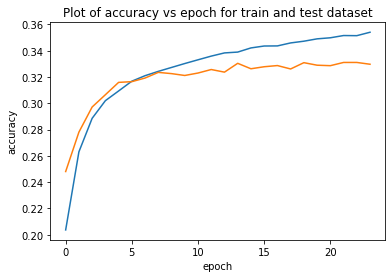

In [90]:
import matplotlib.pyplot as plt
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title("Plot of accuracy vs epoch for train and test dataset")
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.show()

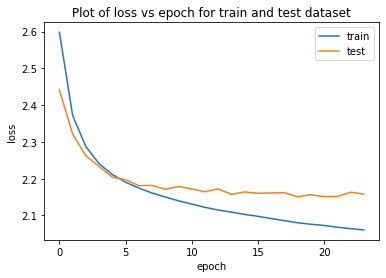

In [91]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title("Plot of loss vs epoch for train and test dataset")
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper right')
plt.show()